In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import shutil
import random
from pathlib import Path
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report

In [3]:
def prepare_dataset():
    # Google Drive mounted path
    MONT_PATH = "/content/drive/MyDrive/DataSet/MontgomerySet/CXR_png"
    SHENZHEN_PATH = "/content/drive/MyDrive/DataSet/ChinaSet_AllFiles/CXR_png"
    TBX11K_PATH = "/content/drive/MyDrive/TB_Dataset/TBnNormal"

    OUTPUT_PATH = "/content/filtered_dataset"
    TB_DIR = os.path.join(OUTPUT_PATH, "TB")
    NORMAL_DIR = os.path.join(OUTPUT_PATH, "Normal")

    os.makedirs(TB_DIR, exist_ok=True)
    os.makedirs(NORMAL_DIR, exist_ok=True)

    def copy_resize(img_path, label, count):
        target_dir = TB_DIR if label == "TB" else NORMAL_DIR
        try:
            img = Image.open(img_path)
            img.verify()  # Check image validity
            img = Image.open(img_path).convert("RGB").resize((224, 224))
            img.save(os.path.join(target_dir, f"{label}_{count}.jpg"), format='JPEG')
        except (UnidentifiedImageError, OSError) as e:
            print(f"Skipped {img_path}: {e}")

    image_records = []

    # Montgomery: TB images have '_1' in name, Normal have '_0'
    for img in Path(MONT_PATH).rglob("*.png"):
        name = img.name
        if "_0.png" in name:
            label = "Normal"
        elif "_1.png" in name:
            label = "TB"
        else:
            continue
        image_records.append((img, label))

    # Shenzhen: Same logic
    for img in Path(SHENZHEN_PATH).rglob("*.png"):
        name = img.name
        if "_0.png" in name:
            label = "Normal"
        elif "_1.png" in name:
            label = "TB"
        else:
            continue
        image_records.append((img, label))

    # TBX11K - already separated
    tbx_tb_path = os.path.join(TBX11K_PATH, "PULMONARY_TUBERCULOSIS")
    tbx_normal_path = os.path.join(TBX11K_PATH, "NORMAL")

    for img in Path(tbx_tb_path).rglob("*.jpg"):
        image_records.append((img, "TB"))
    for img in Path(tbx_normal_path).rglob("*.jpg"):
        image_records.append((img, "Normal"))

    # Shuffle and limit
    random.shuffle(image_records)
    tb_images = [img for img in image_records if img[1] == "TB"][:2500]
    normal_images = [img for img in image_records if img[1] == "Normal"][:2500]

    print(f"Total TB images found: {len(tb_images)}")
    print(f"Total Normal images found: {len(normal_images)}")

    for i, (img_path, label) in enumerate(tb_images + normal_images):
        copy_resize(img_path, label, i)

In [4]:
def get_dataloaders(data_dir, batch_size=32):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

    dataset = datasets.ImageFolder(data_dir, transform=transform)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [5]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // reduction, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        padding = kernel_size // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        max_, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg, max_], dim=1)
        return self.sigmoid(self.conv(x))

class CBAM(nn.Module):
    def __init__(self, in_planes):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_planes)
        self.sa = SpatialAttention()

    def forward(self, x):
        x = x * self.ca(x)
        x = x * self.sa(x)
        return x

class CBAMWDnet(nn.Module):
    def __init__(self, num_classes=2):
        super(CBAMWDnet, self).__init__()
        base_model = models.densenet121(pretrained=True)
        self.features = base_model.features  # no conv0 modification
        self.cbam = CBAM(1024)               # Apply CBAM at the end of DenseNet features
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.cbam(x)
        return self.classifier(x)

Preparing dataset...
Total TB images found: 393
Total Normal images found: 406
Training and evaluating model...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 163MB/s]


Epoch 1, Loss: 0.5895
Epoch 2, Loss: 0.3711
Epoch 3, Loss: 0.2457
Epoch 4, Loss: 0.1332
Epoch 5, Loss: 0.1292
Epoch 6, Loss: 0.0953
Epoch 7, Loss: 0.0763
Epoch 8, Loss: 0.0589
Epoch 9, Loss: 0.0459
Epoch 10, Loss: 0.0167
              precision    recall  f1-score   support

      Normal       0.83      0.90      0.86        84
          TB       0.88      0.79      0.83        76

    accuracy                           0.85       160
   macro avg       0.85      0.85      0.85       160
weighted avg       0.85      0.85      0.85       160



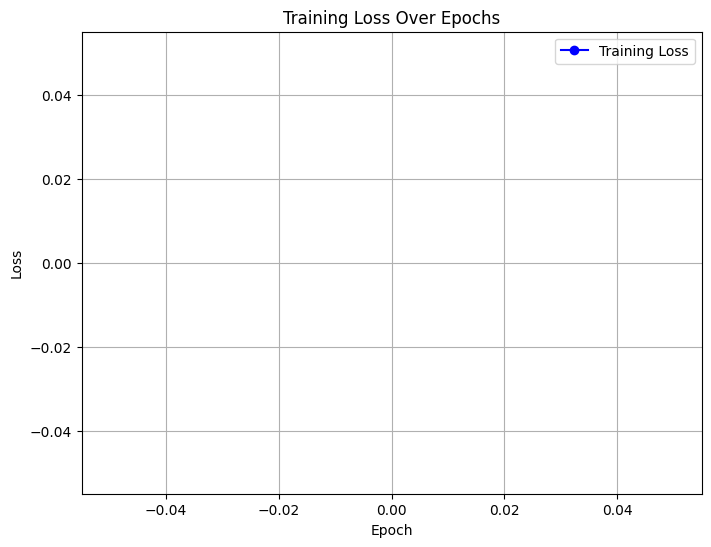

In [6]:
def train_and_evaluate():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    train_loader, test_loader = get_dataloaders("/content/filtered_dataset", batch_size=32)
    model = CBAMWDnet(num_classes=2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    train_losses = []

    for epoch in range(10):
        model.train()
        total_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")

    # Evaluation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1).cpu()
            all_preds.extend(preds)
            all_labels.extend(labels)

    print(classification_report(all_labels, all_preds, target_names=["Normal", "TB"]))
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, 'bo-', label='Training Loss')
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# === MAIN ===

if __name__ == "__main__":
    print("Preparing dataset...")
    prepare_dataset()
    print("Training and evaluating model...")
    train_and_evaluate()